# Importing libraries

In [1]:
import numpy as np
import pandas as pd
import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
from src.models.LSTMModel import LSTMModel
from src.models.SVMModel import SVMModel
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.stem.porter import PorterStemmer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

/Users/shaswatpandey/Development/aicoursework/venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [2]:
# Download nltk library
try:
    nltk.data.find('tokenizers/punkt')
    nltk.corpus.stopwords.words('english')
except LookupError:
    nltk.download('stopwords')
    nltk.download('punkt')

# Importing data
Raw data has been split into train and test data in the ration 90% and 10% respectively. This is done in notebooks/data_split.ipynp file

In [3]:
def read_raw_data(path='data/text.csv'):
    '''
        path: {string} the path directory to read.
        return: {dataframe} pandas dataframe read 
    '''
    return pd.read_csv(path)

In [4]:
rawData = read_raw_data()
rawData.head()

,Unnamed: 0,text,label
0,0,i just feel really helpless and heavy hearted,4
1,1,ive enjoyed being able to slouch about relax a...,0
2,2,i gave up my internship with the dmrg and am f...,4
3,3,i dont know i feel so lost,0
4,4,i am a kindergarten teacher and i am thoroughl...,4


# Exploratory Data Analysis

In [5]:
rawData.shape

(416809, 3)

There are <b>416809 rows</b> in total, and <b>3 columns</b> as seen in the dataframe head as well

In [6]:
rawData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 416809 entries, 0 to 416808
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  416809 non-null  int64 
 1   text        416809 non-null  object
 2   label       416809 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 9.5+ MB


There are <b>no null values</b> in the three columns.

In [7]:
copyRawData = rawData.copy()

# Make label to their strings for EDA
copyRawData['label'] = copyRawData['label'].map({0 : 'sadness', 1 : 'joy', 2: 'love',3 : 'anger' ,4 : 'fear', 5 : 'surprise' })
copyRawData.drop(columns=['Unnamed: 0'], inplace=True)
copyRawData.head()

,text,label
0,i just feel really helpless and heavy hearted,fear
1,ive enjoyed being able to slouch about relax a...,sadness
2,i gave up my internship with the dmrg and am f...,fear
3,i dont know i feel so lost,sadness
4,i am a kindergarten teacher and i am thoroughl...,fear


/var/folders/0b/dc0v6fgs71g8rt_svn4zh26m0000gn/T/ipykernel_50839/2794196274.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=count.index, y=count.values, ax=axs[1], palette="pastel")


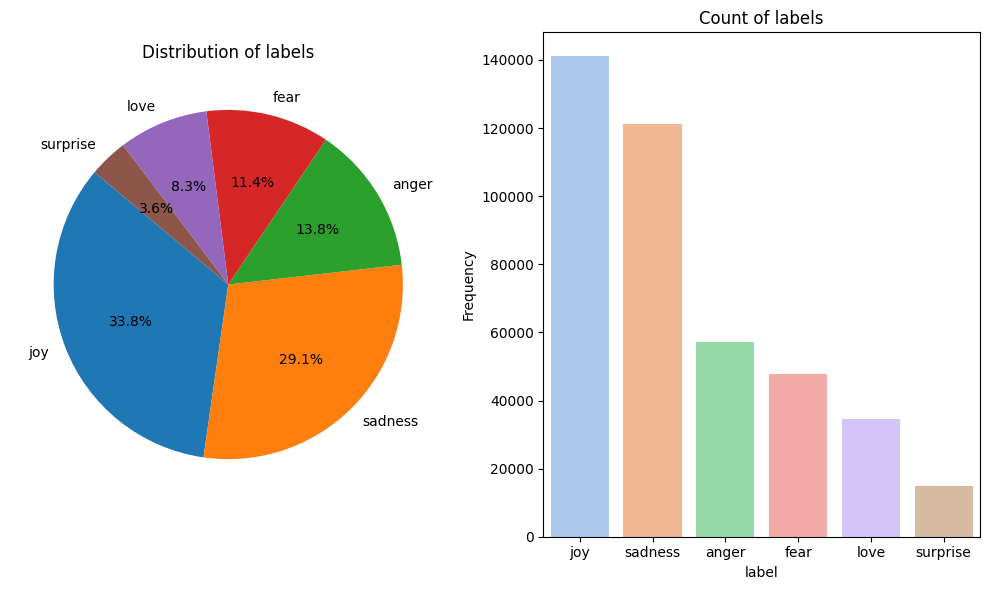

In [8]:
count = copyRawData['label'].value_counts()
fig, axs = plt.subplots(1, 2, figsize=(10, 6), facecolor='white')

# Pie chart in percentage of distribution rounded to 1 significant bit
palette = sns.color_palette("pastel")
sns.set_palette(palette)
axs[0].pie(count, labels=count.index, autopct='%1.1f%%', startangle=140)
axs[0].set_title('Distribution of labels')

# Total count of each label in histogram
sns.barplot(x=count.index, y=count.values, ax=axs[1], palette="pastel")
axs[1].set_title('Count of labels')
axs[1].set_ylabel('Frequency')
plt.tight_layout()

plt.show()

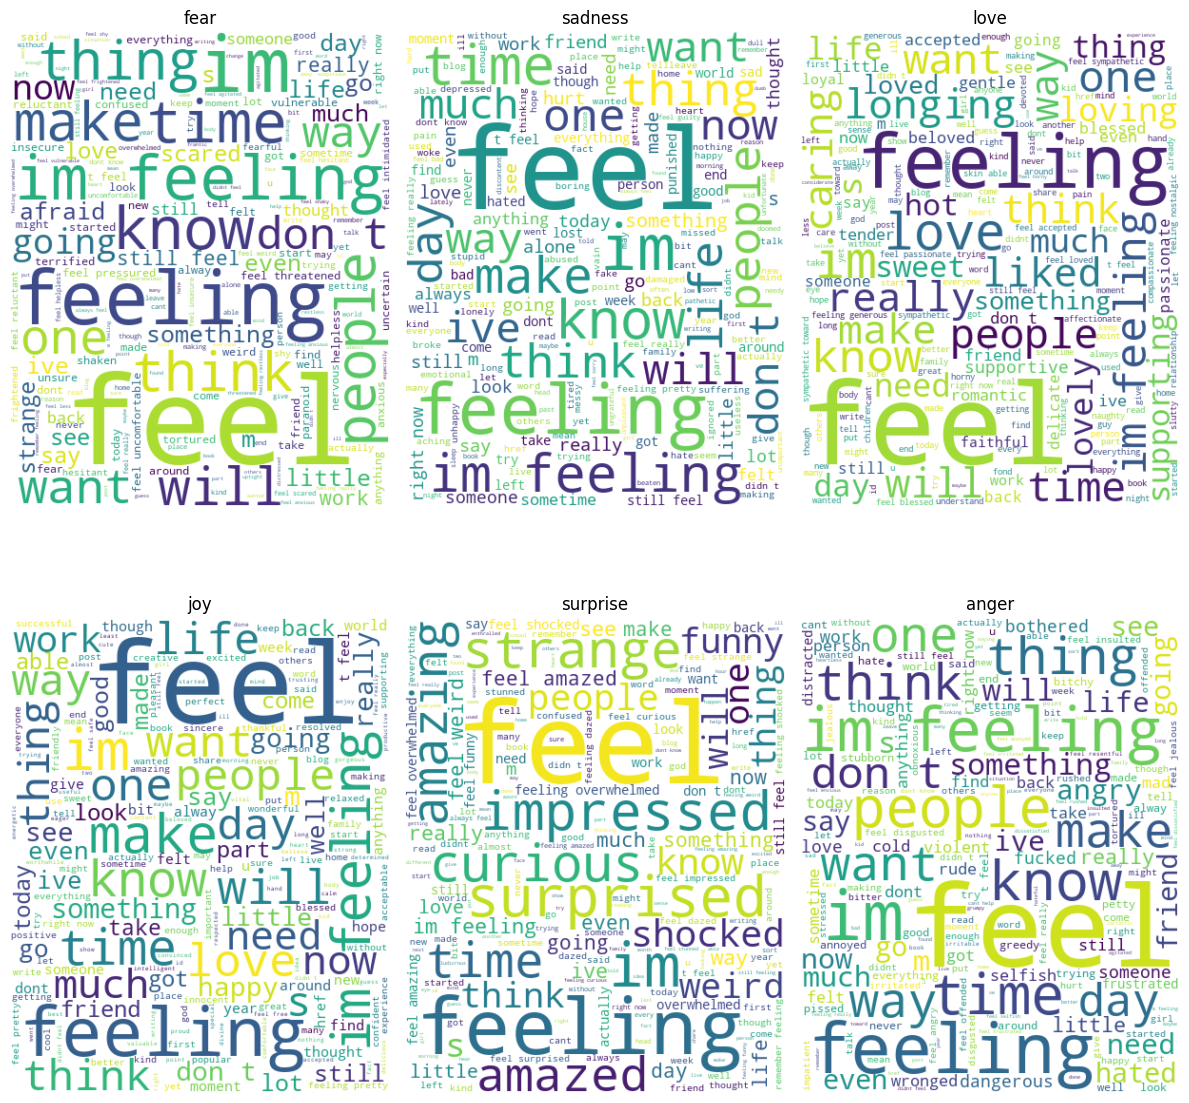

In [9]:
# Wordcloud diagram of each label
plt.figure(figsize=(12,15))
labels = copyRawData['label'].unique()
i = 1
for label in labels:
    plt.subplot(2,3,i)
    labelFilter = copyRawData[copyRawData['label'] == label]
    allTexts = ' '.join(labelFilter['text'])
    wc = WordCloud(height=500, background_color='white').generate(allTexts)
    plt.title(label)
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.tight_layout()
    i = i+1


In [10]:
def count_words(text):
    words = text.split()
    return len(words)
copyRawData['len'] = copyRawData['text'].apply(count_words)
copyRawData['len'].describe()

count    416809.000000
mean         19.211015
std          11.051049
min           1.000000
25%          11.000000
50%          17.000000
75%          25.000000
max         178.000000
Name: len, dtype: float64

The maximum number of words in a row is 178, while minimum is 1. 

In [11]:
copyRawData[copyRawData['len'] == 1].count()

text     26
label    26
len      26
dtype: int64

No information on the text regarding emotion for a 1 word sentence.

In [12]:
copyRawData[copyRawData['len'] == 0].head()

,text,label,len


From the above two filters on dataset for word length of 1 and 2, it can be concluded that word length of <b>1 does not portray any significant emotion though it has labels. It thus will be removed from the dataset as an outlier.</b>

In [13]:
copyRawData[copyRawData['len'] == 178].head()

,text,label,len
348392,a few days back i was waiting for the bus at t...,anger,178


# Cleaning Data

In [14]:
cleanData = rawData.copy()

cleanData['text'] = cleanData['text'].str.replace(r'http\S+', '', regex=True).str.replace("href", "").str.replace("img", "").str.replace("irc", "")


# remove non-alphabetic characters
cleanData['text'] = cleanData['text'].str.replace(r'[^\w\s]', '', regex=True)

# remove multiple whitespaces
cleanData['text'] = cleanData['text'].str.replace(r'\s+', ' ', regex=True)

# remove digits
cleanData['text'] = cleanData['text'].str.replace(r'\d+', '', regex=True)

# change all text to lower case
cleanData['text'] = cleanData['text'].str.lower()


In [15]:
# remove one word texts (outliers)
cleanData['len'] = cleanData['text'].apply(count_words)
print(cleanData.shape)
cleanData.drop(cleanData[cleanData['len'] == 1].index, inplace=True)
print(cleanData.shape)

(416809, 4)
(416783, 4)


In [16]:

# remove stop words
stop = stopwords.words('english')

# remove stop words
cleanData["text"] = cleanData['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))


In [17]:
cleanData['len'] = cleanData['text'].apply(count_words)
cleanData['len'].describe()

count    416783.000000
mean          9.343366
std           5.234755
min           0.000000
25%           5.000000
50%           8.000000
75%          12.000000
max          79.000000
Name: len, dtype: float64

In [18]:
cleanData.drop(cleanData[cleanData['len'] == 0].index, inplace=True)

The maximum word length after data cleaning is 79

In [19]:
cleanData = cleanData.drop_duplicates()

In [20]:
cleanData.shape

(416777, 4)

In [21]:
min_class_size = cleanData['label'].value_counts().min()
balanced_df = pd.concat([cleanData[cleanData['label'] == cls].sample(min_class_size, replace=True) for cls in cleanData['label'].unique()])
balanced_df.reset_index(drop=True, inplace=True)
balanced_df = balanced_df.sample(frac=1).reset_index(drop=True)

# Random Forest

In [22]:
X = balanced_df['text'].values
Y = balanced_df['label'].values
vectorizer = TfidfVectorizer()
vectorizer.fit(X)
X = vectorizer.transform(X)


In [73]:
xTrain, xTest, yTrain, yTest = train_test_split(X, Y, test_size=0.2,random_state=20, shuffle=True)
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42, verbose=2)

In [36]:
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None],
    'min_samples_split': [2, 5, 10],
}
grid_search = GridSearchCV(rf_classifier, param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=2)

In [37]:
grid_search.fit(xTrain, yTrain)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
building tree 1 of 50
building tree 1 of 50
building tree 1 of 50
building tree 1 of 100
building tree 1 of 50
building tree 1 of 100
building tree 1 of 50
building tree 1 of 100
building tree 2 of 50
building tree 2 of 50
building tree 2 of 50
building tree 2 of 50
building tree 2 of 100
building tree 2 of 100
building tree 2 of 100
building tree 2 of 50
building tree 3 of 50
building tree 3 of 100
building tree 3 of 50
building tree 3 of 100
building tree 3 of 100
building tree 3 of 50
building tree 3 of 50
building tree 3 of 50
building tree 4 of 50
building tree 4 of 100
building tree 4 of 50
building tree 4 of 100
building tree 4 of 50
building tree 4 of 100
building tree 4 of 50
building tree 4 of 50
building tree 5 of 50
building tree 5 of 100
building tree 5 of 50
building tree 5 of 50
building tree 5 of 100
building tree 5 of 50
building tree 5 of 50
building tree 5 of 100
building tree 6 of 50
building tree 6 of 100


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:  1.6min


building tree 41 of 50
building tree 40 of 100
building tree 40 of 100


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:  1.6min
[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:  1.6min


building tree 41 of 50
building tree 41 of 50
building tree 40 of 50
building tree 40 of 100
building tree 40 of 50
building tree 42 of 50


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:  1.6min


building tree 41 of 100


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:  1.6min


building tree 41 of 100
building tree 42 of 50
building tree 42 of 50


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:  1.6min
[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:  1.6min


building tree 41 of 100
building tree 41 of 50


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:  1.6min


building tree 41 of 50
building tree 43 of 50
building tree 42 of 100
building tree 42 of 100
building tree 43 of 50
building tree 43 of 50
building tree 42 of 100
building tree 42 of 50
building tree 42 of 50
building tree 44 of 50
building tree 43 of 100
building tree 43 of 100
building tree 44 of 50
building tree 44 of 50
building tree 43 of 50
building tree 43 of 100
building tree 45 of 50
building tree 43 of 50
building tree 44 of 100
building tree 44 of 100
building tree 45 of 50
building tree 44 of 100
building tree 44 of 50
building tree 45 of 50
building tree 44 of 50
building tree 46 of 50
building tree 45 of 100
building tree 45 of 100
building tree 46 of 50
building tree 45 of 100
building tree 46 of 50
building tree 45 of 50
building tree 47 of 50
building tree 45 of 50
building tree 46 of 100
building tree 46 of 100
building tree 47 of 50
building tree 47 of 50
building tree 46 of 50
building tree 46 of 100
building tree 48 of 50
building tree 47 of 100
building tree 46 o

[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.5s


[CV] END max_depth=None, min_samples_split=2, n_estimators=50; total time= 2.0min
building tree 1 of 100
building tree 50 of 100
building tree 50 of 50


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.7s
[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.7s


[CV] END max_depth=None, min_samples_split=2, n_estimators=50; total time= 2.0min
[CV] END max_depth=None, min_samples_split=2, n_estimators=50; total time= 2.0min
building tree 50 of 100
building tree 1 of 100
building tree 1 of 200
building tree 50 of 50
building tree 51 of 100
building tree 51 of 100
building tree 2 of 100
building tree 51 of 100
building tree 2 of 100
building tree 2 of 200


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.6s


[CV] END max_depth=None, min_samples_split=2, n_estimators=50; total time= 2.0min
building tree 1 of 200
building tree 52 of 100
building tree 52 of 100
building tree 3 of 100


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.6s


[CV] END max_depth=None, min_samples_split=2, n_estimators=50; total time= 2.1min
building tree 1 of 200
building tree 3 of 200
building tree 3 of 100
building tree 52 of 100
building tree 2 of 200
building tree 53 of 100
building tree 53 of 100
building tree 4 of 100
building tree 2 of 200
building tree 4 of 100
building tree 4 of 200
building tree 53 of 100
building tree 3 of 200
building tree 54 of 100
building tree 54 of 100
building tree 5 of 100
building tree 3 of 200
building tree 5 of 100
building tree 54 of 100
building tree 5 of 200
building tree 4 of 200
building tree 55 of 100
building tree 55 of 100
building tree 6 of 100
building tree 4 of 200
building tree 6 of 100
building tree 5 of 200
building tree 55 of 100
building tree 6 of 200
building tree 56 of 100
building tree 7 of 100
building tree 56 of 100
building tree 5 of 200
building tree 7 of 100
building tree 56 of 100
building tree 6 of 200
building tree 7 of 200
building tree 57 of 100
building tree 8 of 100
buildin

[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:  1.6min


building tree 41 of 100
building tree 40 of 200
building tree 39 of 200
building tree 90 of 100


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:  1.6min


building tree 41 of 100
building tree 38 of 200
building tree 90 of 100
building tree 89 of 100
building tree 40 of 200
building tree 41 of 200
building tree 42 of 100


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:  1.6min


building tree 91 of 100
building tree 42 of 100
building tree 91 of 100
building tree 39 of 200
building tree 90 of 100
building tree 41 of 200
building tree 92 of 100
building tree 42 of 200
building tree 43 of 100


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:  1.6min


building tree 43 of 100
building tree 92 of 100
building tree 40 of 200
building tree 91 of 100
building tree 93 of 100
building tree 43 of 200
building tree 44 of 100
building tree 42 of 200
building tree 44 of 100


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:  1.6min


building tree 41 of 200
building tree 93 of 100
building tree 92 of 100
building tree 94 of 100
building tree 45 of 100
building tree 43 of 200
building tree 44 of 200
building tree 45 of 100
building tree 42 of 200
building tree 94 of 100
building tree 93 of 100
building tree 46 of 100
building tree 44 of 200
building tree 95 of 100
building tree 45 of 200
building tree 46 of 100
building tree 95 of 100
building tree 43 of 200
building tree 94 of 100
building tree 47 of 100
building tree 46 of 200
building tree 96 of 100
building tree 45 of 200
building tree 47 of 100
building tree 96 of 100
building tree 44 of 200
building tree 95 of 100
building tree 48 of 100
building tree 47 of 200
building tree 46 of 200
building tree 97 of 100
building tree 48 of 100
building tree 97 of 100
building tree 45 of 200
building tree 96 of 100
building tree 48 of 200
building tree 47 of 200
building tree 49 of 100
building tree 98 of 100
building tree 49 of 100
building tree 98 of 100
building tree 46

[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.6s


building tree 49 of 200
building tree 100 of 100


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.8s


[CV] END max_depth=None, min_samples_split=2, n_estimators=100; total time= 4.1min
building tree 1 of 200
building tree 52 of 200
[CV] END max_depth=None, min_samples_split=2, n_estimators=100; total time= 4.1min
building tree 1 of 200
building tree 53 of 100
building tree 51 of 200
building tree 53 of 100
building tree 50 of 200
building tree 2 of 200


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.6s


building tree 53 of 200
building tree 2 of 200
building tree 54 of 100
building tree 54 of 100
building tree 52 of 200
[CV] END max_depth=None, min_samples_split=2, n_estimators=100; total time= 4.1min
building tree 1 of 50
building tree 51 of 200
building tree 3 of 200
building tree 54 of 200
building tree 2 of 50
building tree 3 of 200
building tree 55 of 100
building tree 55 of 100
building tree 53 of 200
building tree 52 of 200
building tree 3 of 50
building tree 4 of 200
building tree 55 of 200
building tree 4 of 200
building tree 56 of 100
building tree 56 of 100
building tree 54 of 200
building tree 4 of 50
building tree 53 of 200
building tree 5 of 200
building tree 56 of 200
building tree 57 of 100
building tree 5 of 200
building tree 57 of 100
building tree 5 of 50
building tree 55 of 200
building tree 54 of 200
building tree 6 of 200
building tree 6 of 50
building tree 58 of 100
building tree 57 of 200
building tree 58 of 100
building tree 6 of 200
building tree 56 of 200
bu

[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:  1.2min


building tree 82 of 200
building tree 32 of 200
building tree 79 of 200
building tree 81 of 200
building tree 84 of 100
building tree 32 of 200
building tree 42 of 50
building tree 84 of 100
building tree 83 of 200
building tree 33 of 200
building tree 80 of 200
building tree 43 of 50
building tree 85 of 100
building tree 82 of 200
building tree 33 of 200
building tree 85 of 100
building tree 84 of 200
building tree 44 of 50
building tree 34 of 200
building tree 81 of 200
building tree 86 of 100
building tree 83 of 200
building tree 34 of 200
building tree 86 of 100
building tree 45 of 50
building tree 85 of 200
building tree 35 of 200
building tree 82 of 200
building tree 87 of 100
building tree 84 of 200
building tree 87 of 100
building tree 35 of 200
building tree 46 of 50
building tree 86 of 200
building tree 36 of 200
building tree 47 of 50
building tree 83 of 200
building tree 88 of 100
building tree 85 of 200
building tree 88 of 100
building tree 36 of 200
building tree 87 of 20

[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.5s


[CV] END max_depth=None, min_samples_split=5, n_estimators=50; total time= 1.5min
building tree 1 of 50
building tree 91 of 100
building tree 39 of 200
building tree 86 of 200
building tree 88 of 200
building tree 90 of 200
building tree 92 of 100
building tree 2 of 50
building tree 40 of 200
building tree 92 of 100
building tree 89 of 200
building tree 40 of 200
building tree 87 of 200
building tree 3 of 50
building tree 91 of 200
building tree 93 of 100
building tree 41 of 200


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:  1.6min


building tree 93 of 100
building tree 90 of 200
building tree 41 of 200
building tree 4 of 50


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:  1.6min


building tree 88 of 200
building tree 92 of 200
building tree 94 of 100
building tree 42 of 200
building tree 5 of 50
building tree 94 of 100
building tree 91 of 200
building tree 42 of 200
building tree 89 of 200
building tree 93 of 200
building tree 95 of 100
building tree 6 of 50
building tree 43 of 200
building tree 92 of 200
building tree 95 of 100
building tree 43 of 200
building tree 90 of 200
building tree 7 of 50
building tree 94 of 200
building tree 96 of 100
building tree 44 of 200
building tree 93 of 200
building tree 96 of 100
building tree 44 of 200
building tree 8 of 50
building tree 91 of 200
building tree 95 of 200
building tree 97 of 100
building tree 45 of 200
building tree 9 of 50
building tree 94 of 200
building tree 45 of 200
building tree 97 of 100
building tree 92 of 200
building tree 96 of 200
building tree 10 of 50
building tree 98 of 100
building tree 46 of 200
building tree 95 of 200
building tree 46 of 200
building tree 98 of 100
building tree 93 of 200
bui

[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.5s


building tree 49 of 200
building tree 15 of 50
[CV] END max_depth=None, min_samples_split=2, n_estimators=100; total time= 4.0min
building tree 1 of 50
building tree 96 of 200


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.6s


building tree 100 of 200
building tree 50 of 200
[CV] END max_depth=None, min_samples_split=2, n_estimators=100; total time= 4.1min
building tree 1 of 50
building tree 16 of 50
building tree 99 of 200
building tree 2 of 50
building tree 50 of 200
building tree 2 of 50
building tree 97 of 200
building tree 17 of 50
building tree 101 of 200
building tree 51 of 200
building tree 3 of 50
building tree 100 of 200
building tree 3 of 50
building tree 51 of 200
building tree 18 of 50
building tree 98 of 200
building tree 4 of 50
building tree 102 of 200
building tree 52 of 200
building tree 4 of 50
building tree 101 of 200
building tree 19 of 50
building tree 5 of 50
building tree 52 of 200
building tree 99 of 200
building tree 5 of 50
building tree 53 of 200
building tree 103 of 200
building tree 20 of 50
building tree 102 of 200
building tree 6 of 50
building tree 6 of 50
building tree 53 of 200
building tree 21 of 50
building tree 100 of 200
building tree 7 of 50
building tree 54 of 200
bui

[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:  1.1min


building tree 41 of 50
building tree 26 of 50
building tree 117 of 200
building tree 27 of 50
building tree 68 of 200
building tree 118 of 200
building tree 114 of 200
building tree 69 of 200
building tree 42 of 50
building tree 27 of 50
building tree 28 of 50
building tree 69 of 200
building tree 118 of 200
building tree 119 of 200
building tree 43 of 50
building tree 28 of 50
building tree 115 of 200
building tree 70 of 200
building tree 29 of 50
building tree 70 of 200
building tree 120 of 200
building tree 119 of 200
building tree 44 of 50
building tree 29 of 50
building tree 30 of 50
building tree 116 of 200
building tree 71 of 200
building tree 45 of 50
building tree 30 of 50
building tree 31 of 50
building tree 71 of 200
building tree 121 of 200
building tree 120 of 200
building tree 46 of 50
building tree 117 of 200
building tree 72 of 200
building tree 31 of 50
building tree 32 of 50
building tree 72 of 200
building tree 122 of 200
building tree 121 of 200
building tree 47 of 

[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.5s


building tree 124 of 200
[CV] END max_depth=None, min_samples_split=5, n_estimators=50; total time= 1.4min
building tree 1 of 50
building tree 76 of 200
building tree 121 of 200
building tree 76 of 200
building tree 38 of 50
building tree 2 of 50
building tree 37 of 50
building tree 126 of 200
building tree 125 of 200
building tree 77 of 200
building tree 39 of 50
building tree 122 of 200
building tree 3 of 50
building tree 38 of 50
building tree 77 of 200
building tree 127 of 200
building tree 40 of 50
building tree 78 of 200
building tree 126 of 200
building tree 4 of 50
building tree 39 of 50
building tree 123 of 200
building tree 78 of 200
building tree 128 of 200
building tree 41 of 50


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:  1.1min


building tree 5 of 50
building tree 40 of 50
building tree 79 of 200
building tree 127 of 200
building tree 124 of 200
building tree 42 of 50
building tree 6 of 50
building tree 79 of 200
building tree 129 of 200
building tree 41 of 50


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:  1.1min


building tree 80 of 200
building tree 128 of 200
building tree 43 of 50
building tree 7 of 50
building tree 125 of 200
building tree 42 of 50
building tree 80 of 200
building tree 130 of 200
building tree 44 of 50
building tree 8 of 50
building tree 81 of 200
building tree 129 of 200
building tree 43 of 50
building tree 126 of 200
building tree 45 of 50
building tree 81 of 200
building tree 131 of 200
building tree 9 of 50
building tree 44 of 50
building tree 82 of 200
building tree 46 of 50
building tree 127 of 200
building tree 130 of 200
building tree 10 of 50
building tree 82 of 200
building tree 45 of 50
building tree 132 of 200
building tree 47 of 50
building tree 83 of 200
building tree 11 of 50
building tree 128 of 200
building tree 46 of 50
building tree 131 of 200
building tree 83 of 200
building tree 48 of 50
building tree 133 of 200
building tree 12 of 50
building tree 84 of 200
building tree 47 of 50
building tree 129 of 200
building tree 49 of 50
building tree 132 of 200


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.6s


building tree 1 of 100
building tree 50 of 50
building tree 131 of 200
building tree 134 of 200
building tree 16 of 50
building tree 86 of 200
building tree 2 of 100
building tree 136 of 200
building tree 87 of 200


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.6s


[CV] END max_depth=None, min_samples_split=5, n_estimators=50; total time= 1.4min
building tree 1 of 100
building tree 132 of 200
building tree 17 of 50
building tree 135 of 200
building tree 3 of 100
building tree 87 of 200
building tree 137 of 200
building tree 2 of 100
building tree 88 of 200
building tree 18 of 50
building tree 4 of 100
building tree 133 of 200
building tree 136 of 200
building tree 3 of 100
building tree 88 of 200
building tree 19 of 50
building tree 138 of 200
building tree 5 of 100
building tree 89 of 200
building tree 4 of 100
building tree 134 of 200
building tree 137 of 200
building tree 20 of 50
building tree 6 of 100
building tree 89 of 200
building tree 139 of 200
building tree 90 of 200
building tree 5 of 100
building tree 21 of 50
building tree 7 of 100
building tree 135 of 200
building tree 138 of 200
building tree 90 of 200
building tree 140 of 200
building tree 6 of 100
building tree 22 of 50
building tree 91 of 200
building tree 8 of 100
building tre

[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:  1.1min


building tree 149 of 200
building tree 152 of 200
building tree 104 of 200
building tree 105 of 200
building tree 154 of 200
building tree 28 of 100
building tree 26 of 100
building tree 42 of 50
building tree 150 of 200
building tree 153 of 200
building tree 105 of 200
building tree 29 of 100
building tree 27 of 100
building tree 43 of 50
building tree 106 of 200
building tree 155 of 200
building tree 30 of 100
building tree 151 of 200
building tree 154 of 200
building tree 106 of 200
building tree 28 of 100
building tree 44 of 50
building tree 156 of 200
building tree 107 of 200
building tree 31 of 100
building tree 29 of 100
building tree 45 of 50
building tree 155 of 200
building tree 152 of 200
building tree 107 of 200
building tree 32 of 100
building tree 157 of 200
building tree 108 of 200
building tree 30 of 100
building tree 46 of 50
building tree 108 of 200
building tree 156 of 200
building tree 153 of 200
building tree 31 of 100
building tree 33 of 100
building tree 47 of 50

[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.5s


[CV] END max_depth=None, min_samples_split=5, n_estimators=50; total time= 1.4min
building tree 1 of 100
building tree 112 of 200
building tree 36 of 100
building tree 38 of 100
building tree 160 of 200
building tree 2 of 100
building tree 157 of 200
building tree 113 of 200


[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:  6.5min


building tree 162 of 200
building tree 37 of 100
building tree 39 of 100
building tree 113 of 200
building tree 3 of 100
building tree 161 of 200
building tree 38 of 100
building tree 114 of 200
building tree 40 of 100
building tree 158 of 200
building tree 163 of 200
building tree 4 of 100
building tree 114 of 200
building tree 39 of 100
building tree 162 of 200
building tree 41 of 100


[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:  6.5min
[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:  1.1min


building tree 115 of 200
building tree 5 of 100
building tree 159 of 200
building tree 164 of 200
building tree 40 of 100
building tree 115 of 200
building tree 42 of 100
building tree 163 of 200
building tree 6 of 100


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:  1.1min


building tree 41 of 100
building tree 116 of 200
building tree 160 of 200
building tree 43 of 100
building tree 165 of 200
building tree 116 of 200
building tree 164 of 200
building tree 7 of 100
building tree 42 of 100
building tree 44 of 100
building tree 117 of 200
building tree 161 of 200
building tree 166 of 200
building tree 117 of 200
building tree 43 of 100
building tree 8 of 100
building tree 45 of 100
building tree 165 of 200
building tree 118 of 200
building tree 44 of 100
building tree 162 of 200
building tree 9 of 100


[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:  6.6min


building tree 118 of 200
building tree 46 of 100
building tree 167 of 200
building tree 166 of 200
building tree 10 of 100
building tree 45 of 100
building tree 119 of 200
building tree 47 of 100
building tree 163 of 200
building tree 168 of 200
building tree 119 of 200
building tree 46 of 100
building tree 11 of 100
building tree 167 of 200
building tree 48 of 100
building tree 120 of 200
building tree 169 of 200
building tree 164 of 200
building tree 47 of 100
building tree 12 of 100
building tree 120 of 200
building tree 49 of 100
building tree 168 of 200
building tree 121 of 200
building tree 13 of 100
building tree 48 of 100
building tree 170 of 200
building tree 50 of 100
building tree 165 of 200
building tree 121 of 200
building tree 169 of 200
building tree 14 of 100
building tree 49 of 100
building tree 51 of 100
building tree 122 of 200
building tree 171 of 200
building tree 166 of 200
building tree 122 of 200
building tree 15 of 100
building tree 50 of 100
building tree 52 o

[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:  1.1min


building tree 41 of 100
building tree 190 of 200
building tree 188 of 200
building tree 76 of 100
building tree 79 of 100
building tree 185 of 200
building tree 42 of 100
building tree 142 of 200
building tree 77 of 100
building tree 142 of 200
building tree 191 of 200
building tree 189 of 200
building tree 80 of 100
building tree 43 of 100
building tree 186 of 200
building tree 78 of 100
building tree 143 of 200
building tree 143 of 200
building tree 81 of 100
building tree 44 of 100
building tree 192 of 200
building tree 190 of 200
building tree 79 of 100
building tree 187 of 200
building tree 144 of 200
building tree 82 of 100
building tree 45 of 100
building tree 144 of 200
building tree 80 of 100
building tree 193 of 200
building tree 191 of 200
building tree 46 of 100
building tree 83 of 100
building tree 188 of 200
building tree 145 of 200
building tree 81 of 100
building tree 145 of 200
building tree 194 of 200
building tree 47 of 100
building tree 84 of 100
building tree 192 o

[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.8s


building tree 57 of 100
building tree 153 of 200
building tree 153 of 200
building tree 92 of 100
building tree 196 of 200
building tree 95 of 100


[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    2.5s


building tree 58 of 100
[CV] END max_depth=None, min_samples_split=2, n_estimators=200; total time= 8.1min
building tree 200 of 200


/Users/shaswatpandey/Development/aicoursework/venv/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


building tree 93 of 100
building tree 96 of 100
building tree 154 of 200
building tree 59 of 100
building tree 154 of 200
building tree 1 of 100
building tree 197 of 200
building tree 94 of 100
building tree 97 of 100
building tree 60 of 100
building tree 2 of 100


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.7s


building tree 155 of 200
building tree 198 of 200
building tree 155 of 200
building tree 95 of 100
building tree 98 of 100


[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    2.5s


building tree 61 of 100
building tree 3 of 100
[CV] END max_depth=None, min_samples_split=2, n_estimators=200; total time= 8.2min
building tree 156 of 200
building tree 96 of 100
building tree 1 of 100
building tree 99 of 100
building tree 199 of 200
building tree 156 of 200
building tree 4 of 100
building tree 62 of 100
building tree 97 of 100
building tree 2 of 100
building tree 100 of 100
building tree 157 of 200
building tree 5 of 100
building tree 63 of 100
building tree 157 of 200
building tree 200 of 200
building tree 98 of 100
building tree 3 of 100
building tree 6 of 100
building tree 64 of 100


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.7s


building tree 158 of 200
building tree 158 of 200
building tree 99 of 100
[CV] END max_depth=None, min_samples_split=5, n_estimators=100; total time= 2.9min
building tree 1 of 200
building tree 4 of 100


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.6s


building tree 65 of 100
building tree 7 of 100
building tree 159 of 200
building tree 100 of 100
building tree 2 of 200
building tree 5 of 100


[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    2.4s


building tree 159 of 200
building tree 66 of 100
building tree 8 of 100
[CV] END max_depth=None, min_samples_split=2, n_estimators=200; total time= 8.3min
building tree 3 of 200
building tree 1 of 200
building tree 6 of 100
building tree 160 of 200


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.5s


building tree 67 of 100
building tree 9 of 100
building tree 160 of 200
[CV] END max_depth=None, min_samples_split=5, n_estimators=100; total time= 2.9min
building tree 1 of 200
building tree 2 of 200
building tree 4 of 200
building tree 7 of 100
building tree 68 of 100
building tree 10 of 100
building tree 161 of 200
building tree 2 of 200
building tree 161 of 200
building tree 3 of 200
building tree 5 of 200
building tree 8 of 100
building tree 69 of 100
building tree 11 of 100
building tree 3 of 200
building tree 4 of 200
building tree 162 of 200


[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:  6.4min


building tree 6 of 200


[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:  6.4min


building tree 162 of 200
building tree 9 of 100
building tree 70 of 100
building tree 12 of 100
building tree 4 of 200
building tree 5 of 200
building tree 7 of 200
building tree 163 of 200
building tree 71 of 100
building tree 10 of 100
building tree 13 of 100
building tree 5 of 200
building tree 163 of 200
building tree 6 of 200
building tree 8 of 200
building tree 11 of 100
building tree 72 of 100
building tree 14 of 100
building tree 164 of 200
building tree 6 of 200
building tree 7 of 200
building tree 164 of 200
building tree 9 of 200
building tree 12 of 100
building tree 73 of 100
building tree 15 of 100
building tree 7 of 200
building tree 165 of 200
building tree 10 of 200
building tree 8 of 200
building tree 13 of 100
building tree 16 of 100
building tree 74 of 100
building tree 165 of 200
building tree 8 of 200
building tree 11 of 200
building tree 9 of 200
building tree 14 of 100
building tree 17 of 100
building tree 166 of 200
building tree 75 of 100
building tree 9 of 200

[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:  1.2min


building tree 41 of 100
building tree 33 of 200
building tree 36 of 200
building tree 39 of 100
building tree 100 of 100
building tree 35 of 200
building tree 184 of 200
building tree 42 of 100
building tree 34 of 200
building tree 184 of 200
building tree 40 of 100
building tree 37 of 200
building tree 36 of 200


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.6s


building tree 43 of 100
building tree 35 of 200


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:  1.2min


building tree 41 of 100
building tree 38 of 200
[CV] END max_depth=None, min_samples_split=5, n_estimators=100; total time= 2.9min
building tree 185 of 200
building tree 185 of 200
building tree 1 of 200
building tree 37 of 200
building tree 36 of 200
building tree 44 of 100
building tree 42 of 100
building tree 39 of 200
building tree 2 of 200
building tree 38 of 200
building tree 186 of 200
building tree 186 of 200
building tree 37 of 200
building tree 45 of 100
building tree 40 of 200
building tree 43 of 100
building tree 3 of 200
building tree 39 of 200
building tree 38 of 200
building tree 46 of 100
building tree 41 of 200
building tree 44 of 100
building tree 187 of 200


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:  1.2min


building tree 187 of 200
building tree 4 of 200
building tree 40 of 200
building tree 47 of 100
building tree 39 of 200
building tree 45 of 100
building tree 42 of 200
building tree 5 of 200
building tree 188 of 200
building tree 188 of 200
building tree 41 of 200


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:  1.1min


building tree 40 of 200
building tree 48 of 100
building tree 46 of 100
building tree 43 of 200
building tree 6 of 200
building tree 42 of 200
building tree 49 of 100


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:  1.2min


building tree 41 of 200
building tree 189 of 200
building tree 189 of 200
building tree 47 of 100
building tree 44 of 200
building tree 7 of 200
building tree 43 of 200
building tree 50 of 100
building tree 42 of 200
building tree 48 of 100
building tree 45 of 200
building tree 190 of 200
building tree 8 of 200
building tree 190 of 200
building tree 44 of 200
building tree 51 of 100
building tree 43 of 200
building tree 49 of 100
building tree 46 of 200
building tree 9 of 200
building tree 191 of 200
building tree 191 of 200
building tree 45 of 200
building tree 52 of 100
building tree 44 of 200
building tree 50 of 100
building tree 47 of 200
building tree 10 of 200
building tree 46 of 200
building tree 53 of 100
building tree 45 of 200
building tree 192 of 200
building tree 192 of 200
building tree 48 of 200
building tree 51 of 100
building tree 11 of 200
building tree 47 of 200
building tree 54 of 100
building tree 46 of 200
building tree 49 of 200
building tree 52 of 100
building tr

[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.7s


building tree 61 of 200


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.7s


building tree 64 of 100
building tree 24 of 200
building tree 67 of 100
building tree 60 of 200
building tree 62 of 200


[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    2.6s


building tree 59 of 200


[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    2.6s


building tree 65 of 100
[CV] END max_depth=None, min_samples_split=2, n_estimators=200; total time= 8.1min
building tree 1 of 200
[CV] END max_depth=None, min_samples_split=2, n_estimators=200; total time= 8.1min
building tree 1 of 50
building tree 25 of 200
building tree 68 of 100
building tree 63 of 200
building tree 61 of 200
building tree 60 of 200
building tree 66 of 100
building tree 2 of 200
building tree 2 of 50
building tree 26 of 200
building tree 69 of 100
building tree 62 of 200
building tree 64 of 200
building tree 61 of 200
building tree 67 of 100
building tree 3 of 200
building tree 3 of 50
building tree 27 of 200
building tree 70 of 100
building tree 63 of 200
building tree 65 of 200
building tree 62 of 200
building tree 68 of 100
building tree 4 of 200
building tree 4 of 50
building tree 28 of 200
building tree 71 of 100
building tree 64 of 200
building tree 66 of 200
building tree 63 of 200
building tree 69 of 100
building tree 5 of 200
building tree 5 of 50
building 

[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:  1.2min


building tree 41 of 200
building tree 77 of 200
building tree 76 of 200
building tree 79 of 200
building tree 18 of 200
building tree 19 of 50
building tree 82 of 100
building tree 85 of 100
building tree 42 of 200
building tree 78 of 200
building tree 77 of 200
building tree 20 of 50
building tree 19 of 200
building tree 80 of 200
building tree 86 of 100
building tree 83 of 100
building tree 43 of 200
building tree 79 of 200
building tree 78 of 200
building tree 21 of 50
building tree 20 of 200
building tree 81 of 200
building tree 84 of 100
building tree 87 of 100
building tree 44 of 200
building tree 80 of 200
building tree 21 of 200
building tree 22 of 50
building tree 79 of 200
building tree 82 of 200
building tree 85 of 100
building tree 88 of 100
building tree 45 of 200
building tree 81 of 200
building tree 22 of 200
building tree 23 of 50
building tree 80 of 200
building tree 83 of 200
building tree 89 of 100
building tree 86 of 100
building tree 46 of 200
building tree 82 of 2

[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.6s


building tree 94 of 200
building tree 37 of 50
building tree 93 of 200
building tree 96 of 200
[CV] END max_depth=None, min_samples_split=5, n_estimators=100; total time= 2.9min
building tree 1 of 50
building tree 59 of 200
building tree 99 of 100
building tree 36 of 200
building tree 95 of 200
building tree 38 of 50
building tree 94 of 200
building tree 60 of 200
building tree 97 of 200
building tree 2 of 50
building tree 100 of 100
building tree 37 of 200
building tree 39 of 50
building tree 96 of 200
building tree 95 of 200
building tree 3 of 50
building tree 61 of 200
building tree 98 of 200
building tree 40 of 50
building tree 38 of 200
building tree 97 of 200


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.6s


building tree 4 of 50
building tree 96 of 200
building tree 62 of 200
[CV] END max_depth=None, min_samples_split=5, n_estimators=100; total time= 2.9min
building tree 99 of 200
building tree 1 of 50


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:  1.1min


building tree 41 of 50
building tree 39 of 200
building tree 98 of 200
building tree 5 of 50
building tree 97 of 200
building tree 63 of 200
building tree 2 of 50
building tree 100 of 200
building tree 42 of 50
building tree 99 of 200
building tree 6 of 50
building tree 40 of 200
building tree 98 of 200
building tree 64 of 200
building tree 3 of 50
building tree 101 of 200
building tree 43 of 50
building tree 100 of 200
building tree 7 of 50


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:  1.2min


building tree 41 of 200
building tree 99 of 200
building tree 65 of 200
building tree 4 of 50
building tree 102 of 200
building tree 44 of 50
building tree 8 of 50
building tree 101 of 200
building tree 42 of 200
building tree 100 of 200
building tree 66 of 200
building tree 5 of 50
building tree 103 of 200
building tree 45 of 50
building tree 9 of 50
building tree 102 of 200
building tree 67 of 200
building tree 43 of 200
building tree 101 of 200
building tree 6 of 50
building tree 46 of 50
building tree 104 of 200
building tree 10 of 50
building tree 103 of 200
building tree 68 of 200
building tree 44 of 200
building tree 102 of 200
building tree 7 of 50
building tree 47 of 50
building tree 105 of 200
building tree 11 of 50
building tree 104 of 200
building tree 69 of 200
building tree 45 of 200
building tree 103 of 200
building tree 8 of 50
building tree 48 of 50
building tree 106 of 200
building tree 12 of 50
building tree 70 of 200
building tree 105 of 200
building tree 46 of 200


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.5s


building tree 109 of 200
building tree 15 of 50
[CV] END max_depth=None, min_samples_split=10, n_estimators=50; total time= 1.4min
building tree 1 of 50
building tree 73 of 200
building tree 108 of 200
building tree 49 of 200
building tree 12 of 50
building tree 107 of 200
building tree 16 of 50
building tree 110 of 200
building tree 2 of 50
building tree 74 of 200
building tree 109 of 200
building tree 13 of 50
building tree 108 of 200
building tree 50 of 200
building tree 17 of 50
building tree 3 of 50
building tree 111 of 200
building tree 75 of 200
building tree 14 of 50
building tree 110 of 200
building tree 18 of 50
building tree 109 of 200
building tree 4 of 50
building tree 51 of 200
building tree 112 of 200
building tree 15 of 50
building tree 76 of 200
building tree 111 of 200
building tree 19 of 50
building tree 110 of 200
building tree 5 of 50
building tree 52 of 200
building tree 113 of 200
building tree 16 of 50
building tree 77 of 200
building tree 20 of 50
building tree

[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:  1.1min


building tree 41 of 50
building tree 131 of 200
building tree 132 of 200
building tree 134 of 200
building tree 98 of 200
building tree 28 of 50
building tree 74 of 200
building tree 39 of 50
building tree 42 of 50
building tree 132 of 200
building tree 133 of 200
building tree 135 of 200
building tree 99 of 200
building tree 29 of 50
building tree 40 of 50
building tree 75 of 200
building tree 43 of 50
building tree 133 of 200
building tree 134 of 200
building tree 136 of 200
building tree 30 of 50
building tree 100 of 200
building tree 41 of 50


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:  1.1min


building tree 44 of 50
building tree 76 of 200
building tree 134 of 200
building tree 135 of 200
building tree 137 of 200
building tree 101 of 200
building tree 31 of 50
building tree 42 of 50
building tree 45 of 50
building tree 77 of 200
building tree 135 of 200
building tree 136 of 200
building tree 138 of 200
building tree 102 of 200
building tree 32 of 50
building tree 46 of 50
building tree 43 of 50
building tree 78 of 200
building tree 136 of 200
building tree 137 of 200
building tree 103 of 200
building tree 139 of 200
building tree 33 of 50
building tree 47 of 50
building tree 44 of 50
building tree 79 of 200
building tree 137 of 200
building tree 138 of 200
building tree 34 of 50
building tree 140 of 200
building tree 104 of 200
building tree 48 of 50
building tree 45 of 50
building tree 80 of 200
building tree 138 of 200
building tree 139 of 200
building tree 35 of 50
building tree 141 of 200
building tree 49 of 50
building tree 105 of 200
building tree 46 of 50
building tre

[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.5s


[CV] END max_depth=None, min_samples_split=10, n_estimators=50; total time= 1.4min
building tree 1 of 50
building tree 141 of 200
building tree 83 of 200
building tree 142 of 200
building tree 49 of 50
building tree 38 of 50
building tree 144 of 200
building tree 108 of 200
building tree 2 of 50
building tree 142 of 200
building tree 84 of 200
building tree 50 of 50
building tree 143 of 200
building tree 39 of 50
building tree 145 of 200
building tree 3 of 50
building tree 109 of 200
building tree 143 of 200
building tree 85 of 200
building tree 144 of 200
building tree 40 of 50


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.5s


[CV] END max_depth=None, min_samples_split=10, n_estimators=50; total time= 1.4min
building tree 1 of 100
building tree 4 of 50
building tree 146 of 200
building tree 110 of 200
building tree 144 of 200
building tree 86 of 200


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:  1.1min


building tree 41 of 50
building tree 145 of 200
building tree 2 of 100
building tree 5 of 50
building tree 111 of 200
building tree 147 of 200
building tree 145 of 200
building tree 87 of 200
building tree 42 of 50
building tree 146 of 200
building tree 3 of 100
building tree 6 of 50
building tree 112 of 200
building tree 148 of 200
building tree 146 of 200
building tree 88 of 200
building tree 43 of 50
building tree 147 of 200
building tree 7 of 50
building tree 4 of 100
building tree 113 of 200
building tree 149 of 200
building tree 147 of 200
building tree 89 of 200
building tree 44 of 50
building tree 5 of 100
building tree 148 of 200
building tree 8 of 50
building tree 114 of 200
building tree 150 of 200
building tree 148 of 200
building tree 90 of 200
building tree 45 of 50
building tree 6 of 100
building tree 149 of 200
building tree 9 of 50
building tree 115 of 200
building tree 151 of 200
building tree 149 of 200
building tree 46 of 50
building tree 91 of 200
building tree 7 o

[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.5s


building tree 12 of 100
building tree 96 of 200
[CV] END max_depth=None, min_samples_split=10, n_estimators=50; total time= 1.4min
building tree 1 of 100
building tree 15 of 50
building tree 155 of 200
building tree 121 of 200
building tree 157 of 200
building tree 155 of 200
building tree 13 of 100
building tree 97 of 200
building tree 2 of 100
building tree 16 of 50
building tree 156 of 200
building tree 122 of 200
building tree 158 of 200
building tree 156 of 200
building tree 14 of 100
building tree 3 of 100
building tree 98 of 200
building tree 17 of 50
building tree 157 of 200
building tree 4 of 100
building tree 123 of 200
building tree 15 of 100
building tree 159 of 200
building tree 157 of 200
building tree 99 of 200
building tree 18 of 50
building tree 158 of 200
building tree 16 of 100
building tree 5 of 100
building tree 124 of 200
building tree 160 of 200
building tree 19 of 50
building tree 100 of 200
building tree 158 of 200
building tree 159 of 200
building tree 17 of 1

[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:  4.7min


building tree 102 of 200
building tree 161 of 200
building tree 19 of 100
building tree 8 of 100
building tree 22 of 50
building tree 127 of 200
building tree 161 of 200
building tree 163 of 200
building tree 103 of 200


[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:  4.7min


building tree 162 of 200
building tree 20 of 100
building tree 9 of 100
building tree 23 of 50
building tree 128 of 200
building tree 162 of 200


[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:  4.7min


building tree 164 of 200
building tree 104 of 200
building tree 21 of 100
building tree 163 of 200
building tree 24 of 50
building tree 10 of 100
building tree 129 of 200
building tree 163 of 200
building tree 165 of 200
building tree 105 of 200
building tree 22 of 100
building tree 164 of 200
building tree 25 of 50
building tree 11 of 100
building tree 164 of 200
building tree 130 of 200
building tree 166 of 200
building tree 106 of 200
building tree 23 of 100
building tree 165 of 200
building tree 26 of 50
building tree 12 of 100
building tree 131 of 200
building tree 165 of 200
building tree 167 of 200
building tree 107 of 200
building tree 24 of 100
building tree 166 of 200
building tree 13 of 100
building tree 27 of 50
building tree 166 of 200
building tree 132 of 200
building tree 168 of 200
building tree 108 of 200
building tree 25 of 100
building tree 167 of 200
building tree 14 of 100
building tree 28 of 50
building tree 167 of 200
building tree 133 of 200
building tree 169 of

[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:  1.1min


building tree 179 of 200
building tree 145 of 200
building tree 181 of 200
building tree 121 of 200
building tree 39 of 100
building tree 180 of 200
building tree 28 of 100
building tree 42 of 50
building tree 180 of 200
building tree 182 of 200
building tree 146 of 200
building tree 40 of 100
building tree 181 of 200
building tree 29 of 100
building tree 122 of 200
building tree 43 of 50
building tree 181 of 200
building tree 183 of 200


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:  1.1min


building tree 41 of 100
building tree 147 of 200
building tree 30 of 100
building tree 182 of 200
building tree 123 of 200
building tree 44 of 50
building tree 182 of 200
building tree 184 of 200
building tree 42 of 100
building tree 31 of 100
building tree 148 of 200
building tree 124 of 200
building tree 183 of 200
building tree 45 of 50
building tree 183 of 200
building tree 185 of 200
building tree 32 of 100
building tree 43 of 100
building tree 125 of 200
building tree 149 of 200
building tree 46 of 50
building tree 184 of 200
building tree 184 of 200
building tree 186 of 200
building tree 33 of 100
building tree 44 of 100
building tree 47 of 50
building tree 150 of 200
building tree 126 of 200
building tree 185 of 200
building tree 185 of 200
building tree 34 of 100
building tree 187 of 200
building tree 45 of 100
building tree 48 of 50
building tree 151 of 200
building tree 127 of 200
building tree 186 of 200
building tree 186 of 200
building tree 35 of 100
building tree 46 of 1

[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.6s


building tree 189 of 200
[CV] END max_depth=None, min_samples_split=10, n_estimators=50; total time= 1.4min
building tree 1 of 100
building tree 49 of 100
building tree 38 of 100
building tree 191 of 200
building tree 190 of 200
building tree 155 of 200
building tree 190 of 200
building tree 131 of 200
building tree 2 of 100
building tree 50 of 100
building tree 39 of 100
building tree 192 of 200
building tree 156 of 200
building tree 191 of 200
building tree 191 of 200
building tree 3 of 100
building tree 132 of 200
building tree 40 of 100
building tree 51 of 100
building tree 193 of 200
building tree 157 of 200
building tree 192 of 200
building tree 4 of 100
building tree 192 of 200
building tree 133 of 200
building tree 41 of 100
building tree 52 of 100


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:  1.1min


building tree 194 of 200
building tree 158 of 200
building tree 5 of 100
building tree 193 of 200
building tree 193 of 200
building tree 134 of 200
building tree 53 of 100
building tree 42 of 100
building tree 195 of 200
building tree 159 of 200
building tree 6 of 100
building tree 194 of 200
building tree 54 of 100
building tree 194 of 200
building tree 135 of 200
building tree 43 of 100
building tree 7 of 100
building tree 160 of 200
building tree 196 of 200
building tree 195 of 200
building tree 55 of 100
building tree 195 of 200
building tree 44 of 100
building tree 136 of 200
building tree 8 of 100
building tree 197 of 200
building tree 161 of 200
building tree 56 of 100
building tree 196 of 200
building tree 196 of 200
building tree 45 of 100
building tree 137 of 200
building tree 9 of 100
building tree 198 of 200
building tree 162 of 200
building tree 57 of 100


[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:  4.7min


building tree 197 of 200
building tree 46 of 100
building tree 197 of 200
building tree 138 of 200
building tree 10 of 100
building tree 199 of 200
building tree 58 of 100
building tree 163 of 200
building tree 198 of 200
building tree 47 of 100
building tree 139 of 200
building tree 198 of 200
building tree 11 of 100
building tree 59 of 100
building tree 164 of 200
building tree 200 of 200
building tree 199 of 200
building tree 48 of 100
building tree 140 of 200
building tree 199 of 200
building tree 12 of 100
building tree 60 of 100
building tree 49 of 100
building tree 165 of 200
building tree 200 of 200
building tree 141 of 200


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.8s


building tree 200 of 200
building tree 13 of 100
building tree 61 of 100
building tree 50 of 100
building tree 166 of 200
building tree 142 of 200


[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    2.9s
[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.7s


building tree 14 of 100
building tree 62 of 100
[CV] END max_depth=None, min_samples_split=5, n_estimators=200; total time= 5.9min
building tree 51 of 100
building tree 1 of 100


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.8s


building tree 167 of 200
building tree 143 of 200


[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    2.7s


building tree 15 of 100
building tree 52 of 100
building tree 63 of 100
building tree 2 of 100
[CV] END max_depth=None, min_samples_split=5, n_estimators=200; total time= 5.9min


[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    2.8s


building tree 1 of 100
building tree 168 of 200
[CV] END max_depth=None, min_samples_split=5, n_estimators=200; total time= 5.9min
building tree 144 of 200
building tree 1 of 200
building tree 16 of 100
building tree 53 of 100
building tree 64 of 100
building tree 3 of 100
building tree 2 of 100
building tree 169 of 200
building tree 2 of 200
building tree 145 of 200
building tree 17 of 100
building tree 4 of 100
building tree 65 of 100
building tree 54 of 100
building tree 3 of 100
building tree 170 of 200
building tree 3 of 200
building tree 146 of 200
building tree 18 of 100
building tree 66 of 100
building tree 5 of 100
building tree 55 of 100
building tree 4 of 100
building tree 171 of 200
building tree 4 of 200
building tree 19 of 100
building tree 147 of 200
building tree 67 of 100
building tree 6 of 100
building tree 56 of 100
building tree 5 of 100
building tree 5 of 200
building tree 20 of 100
building tree 172 of 200
building tree 148 of 200
building tree 7 of 100
building t

[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:  4.7min


building tree 72 of 100
building tree 83 of 100
building tree 21 of 200
building tree 36 of 100
building tree 187 of 200
building tree 22 of 100
building tree 163 of 200
building tree 23 of 100
building tree 73 of 100
building tree 84 of 100
building tree 22 of 200
building tree 37 of 100
building tree 188 of 200
building tree 23 of 100
building tree 85 of 100
building tree 74 of 100
building tree 164 of 200
building tree 24 of 100
building tree 23 of 200
building tree 38 of 100
building tree 189 of 200
building tree 24 of 100
building tree 86 of 100
building tree 75 of 100
building tree 25 of 100
building tree 165 of 200
building tree 24 of 200
building tree 39 of 100
building tree 190 of 200
building tree 25 of 100
building tree 87 of 100
building tree 76 of 100
building tree 26 of 100
building tree 166 of 200
building tree 25 of 200
building tree 40 of 100
building tree 26 of 100
building tree 77 of 100
building tree 88 of 100
building tree 191 of 200
building tree 27 of 100
buildin

[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:  1.1min


building tree 41 of 100
building tree 27 of 100
building tree 78 of 100
building tree 89 of 100
building tree 28 of 100
building tree 192 of 200
building tree 27 of 200
building tree 168 of 200
building tree 42 of 100
building tree 28 of 100
building tree 90 of 100
building tree 79 of 100
building tree 29 of 100
building tree 28 of 200
building tree 193 of 200
building tree 169 of 200
building tree 43 of 100
building tree 29 of 100
building tree 91 of 100
building tree 29 of 200
building tree 80 of 100
building tree 30 of 100
building tree 194 of 200
building tree 170 of 200
building tree 44 of 100
building tree 92 of 100
building tree 30 of 100
building tree 30 of 200
building tree 81 of 100
building tree 31 of 100
building tree 195 of 200
building tree 45 of 100
building tree 171 of 200
building tree 31 of 100
building tree 93 of 100
building tree 31 of 200
building tree 82 of 100
building tree 32 of 100
building tree 196 of 200
building tree 46 of 100
building tree 172 of 200
buildi

[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.8s


building tree 37 of 100
building tree 88 of 100
building tree 38 of 100
building tree 99 of 100
building tree 52 of 100
building tree 38 of 200
building tree 38 of 100


[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    3.3s


building tree 178 of 200
building tree 89 of 100
[CV] END max_depth=None, min_samples_split=5, n_estimators=200; total time= 5.9min
building tree 1 of 200
building tree 39 of 100
building tree 100 of 100
building tree 53 of 100
building tree 39 of 200
building tree 39 of 100
building tree 90 of 100
building tree 179 of 200
building tree 40 of 100
building tree 2 of 200
building tree 54 of 100


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.6s


building tree 40 of 200
building tree 40 of 100
building tree 91 of 100
building tree 180 of 200
[CV] END max_depth=None, min_samples_split=10, n_estimators=100; total time= 2.8min


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:  1.1min


building tree 3 of 200
building tree 41 of 100
building tree 1 of 200
building tree 55 of 100


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:  1.1min
[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:  1.1min


building tree 41 of 200
building tree 41 of 100
building tree 4 of 200
building tree 92 of 100
building tree 181 of 200
building tree 42 of 100
building tree 2 of 200
building tree 56 of 100
building tree 42 of 200
building tree 42 of 100
building tree 5 of 200
building tree 93 of 100
building tree 43 of 100
building tree 3 of 200
building tree 182 of 200
building tree 57 of 100
building tree 43 of 200
building tree 43 of 100
building tree 6 of 200
building tree 44 of 100
building tree 94 of 100
building tree 4 of 200
building tree 58 of 100
building tree 183 of 200
building tree 44 of 200
building tree 44 of 100
building tree 45 of 100
building tree 7 of 200
building tree 95 of 100
building tree 59 of 100
building tree 5 of 200
building tree 184 of 200
building tree 45 of 200
building tree 45 of 100
building tree 46 of 100
building tree 8 of 200
building tree 96 of 100
building tree 60 of 100
building tree 6 of 200
building tree 185 of 200
building tree 46 of 200
building tree 46 of 1

[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.6s


building tree 190 of 200
building tree 51 of 100
building tree 52 of 100
[CV] END max_depth=None, min_samples_split=10, n_estimators=100; total time= 2.8min
building tree 14 of 200
building tree 1 of 200
building tree 66 of 100
building tree 12 of 200
building tree 52 of 200
building tree 191 of 200
building tree 52 of 100
building tree 53 of 100
building tree 2 of 200
building tree 15 of 200
building tree 67 of 100
building tree 13 of 200
building tree 53 of 200
building tree 53 of 100
building tree 54 of 100
building tree 192 of 200
building tree 3 of 200
building tree 16 of 200
building tree 68 of 100
building tree 14 of 200
building tree 54 of 200
building tree 54 of 100
building tree 55 of 100
building tree 4 of 200
building tree 193 of 200
building tree 17 of 200
building tree 69 of 100
building tree 15 of 200
building tree 55 of 200
building tree 55 of 100
building tree 56 of 100
building tree 18 of 200
building tree 5 of 200
building tree 194 of 200
building tree 70 of 100
buil

[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.8s


building tree 13 of 200
building tree 64 of 200
building tree 78 of 100
building tree 24 of 200
building tree 65 of 100
building tree 64 of 100
building tree 27 of 200


[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    2.6s


building tree 14 of 200
building tree 65 of 200
building tree 79 of 100
building tree 25 of 200
[CV] END max_depth=None, min_samples_split=5, n_estimators=200; total time= 6.0min
building tree 66 of 100
building tree 1 of 200
building tree 65 of 100
building tree 28 of 200
building tree 15 of 200
building tree 66 of 200
building tree 80 of 100
building tree 26 of 200
building tree 67 of 100
building tree 2 of 200
building tree 66 of 100
building tree 29 of 200
building tree 16 of 200
building tree 67 of 200
building tree 81 of 100
building tree 27 of 200
building tree 68 of 100
building tree 3 of 200
building tree 67 of 100
building tree 30 of 200
building tree 17 of 200
building tree 68 of 200
building tree 82 of 100
building tree 28 of 200
building tree 69 of 100
building tree 4 of 200
building tree 68 of 100
building tree 31 of 200
building tree 18 of 200
building tree 69 of 200
building tree 83 of 100
building tree 70 of 100
building tree 29 of 200
building tree 5 of 200
building t

[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:  1.1min


building tree 41 of 200
building tree 80 of 100
building tree 28 of 200
building tree 79 of 200
building tree 39 of 200
building tree 93 of 100
building tree 79 of 100
building tree 15 of 200
building tree 42 of 200
building tree 81 of 100
building tree 29 of 200
building tree 40 of 200
building tree 94 of 100
building tree 80 of 200
building tree 80 of 100
building tree 16 of 200
building tree 43 of 200
building tree 82 of 100
building tree 30 of 200
building tree 95 of 100
building tree 81 of 200
building tree 41 of 200


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:  1.1min


building tree 17 of 200
building tree 81 of 100
building tree 44 of 200
building tree 83 of 100
building tree 96 of 100
building tree 31 of 200
building tree 42 of 200
building tree 82 of 200
building tree 82 of 100
building tree 18 of 200
building tree 45 of 200
building tree 84 of 100
building tree 97 of 100
building tree 32 of 200
building tree 43 of 200
building tree 83 of 200
building tree 83 of 100
building tree 19 of 200
building tree 46 of 200
building tree 85 of 100
building tree 98 of 100
building tree 33 of 200
building tree 44 of 200
building tree 84 of 200
building tree 20 of 200
building tree 84 of 100
building tree 47 of 200
building tree 86 of 100
building tree 99 of 100
building tree 34 of 200
building tree 45 of 200
building tree 85 of 200
building tree 21 of 200
building tree 85 of 100
building tree 48 of 200
building tree 87 of 100
building tree 100 of 100
building tree 35 of 200
building tree 46 of 200
building tree 86 of 200
building tree 22 of 200
building tree 8

[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.8s


building tree 87 of 100
building tree 50 of 200
building tree 89 of 100
[CV] END max_depth=None, min_samples_split=10, n_estimators=100; total time= 2.8min
building tree 48 of 200
building tree 37 of 200
building tree 88 of 200
building tree 24 of 200
building tree 88 of 100
building tree 51 of 200
building tree 90 of 100
building tree 49 of 200
building tree 38 of 200
building tree 89 of 200
building tree 25 of 200
building tree 89 of 100
building tree 52 of 200
building tree 91 of 100
building tree 50 of 200
building tree 39 of 200
building tree 90 of 200
building tree 26 of 200
building tree 90 of 100
building tree 53 of 200
building tree 92 of 100
building tree 51 of 200
building tree 91 of 200
building tree 40 of 200
building tree 27 of 200
building tree 91 of 100
building tree 54 of 200
building tree 93 of 100
building tree 92 of 200
building tree 52 of 200


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:  1.1min


building tree 41 of 200
building tree 28 of 200
building tree 92 of 100
building tree 55 of 200
building tree 94 of 100
building tree 93 of 200
building tree 53 of 200
building tree 42 of 200
building tree 29 of 200
building tree 93 of 100
building tree 56 of 200
building tree 95 of 100
building tree 54 of 200
building tree 43 of 200
building tree 94 of 200
building tree 30 of 200
building tree 94 of 100
building tree 57 of 200
building tree 96 of 100
building tree 55 of 200
building tree 95 of 200
building tree 44 of 200
building tree 31 of 200
building tree 95 of 100
building tree 58 of 200
building tree 97 of 100
building tree 56 of 200
building tree 96 of 200
building tree 45 of 200
building tree 32 of 200
building tree 96 of 100
building tree 59 of 200
building tree 98 of 100
building tree 57 of 200
building tree 46 of 200
building tree 97 of 200
building tree 33 of 200
building tree 97 of 100
building tree 60 of 200
building tree 99 of 100
building tree 58 of 200
building tree 47

[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.6s


building tree 100 of 100
building tree 63 of 200
[CV] END max_depth=None, min_samples_split=10, n_estimators=100; total time= 2.8min
building tree 50 of 200
building tree 61 of 200
building tree 101 of 200
building tree 37 of 200
building tree 64 of 200


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.6s


building tree 51 of 200
building tree 62 of 200
building tree 102 of 200
building tree 38 of 200
[CV] END max_depth=None, min_samples_split=10, n_estimators=100; total time= 2.8min
building tree 65 of 200
building tree 52 of 200
building tree 63 of 200
building tree 103 of 200
building tree 39 of 200
building tree 66 of 200
building tree 53 of 200
building tree 64 of 200
building tree 104 of 200
building tree 40 of 200
building tree 67 of 200
building tree 54 of 200
building tree 65 of 200
building tree 105 of 200
building tree 41 of 200


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:  1.1min


building tree 68 of 200
building tree 55 of 200
building tree 66 of 200
building tree 106 of 200
building tree 42 of 200
building tree 69 of 200
building tree 56 of 200
building tree 67 of 200
building tree 107 of 200
building tree 43 of 200
building tree 70 of 200
building tree 57 of 200
building tree 108 of 200
building tree 68 of 200
building tree 44 of 200
building tree 71 of 200
building tree 58 of 200
building tree 69 of 200
building tree 109 of 200
building tree 45 of 200
building tree 72 of 200
building tree 59 of 200
building tree 70 of 200
building tree 110 of 200
building tree 46 of 200
building tree 73 of 200
building tree 60 of 200
building tree 71 of 200
building tree 111 of 200
building tree 47 of 200
building tree 74 of 200
building tree 61 of 200
building tree 72 of 200
building tree 112 of 200
building tree 48 of 200
building tree 75 of 200
building tree 62 of 200
building tree 73 of 200
building tree 113 of 200
building tree 49 of 200
building tree 76 of 200
building

[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:  4.1min


building tree 162 of 200
building tree 125 of 200
building tree 99 of 200
building tree 123 of 200
building tree 113 of 200
building tree 163 of 200
building tree 126 of 200
building tree 124 of 200
building tree 100 of 200
building tree 114 of 200
building tree 164 of 200
building tree 127 of 200
building tree 125 of 200
building tree 101 of 200
building tree 115 of 200
building tree 165 of 200
building tree 126 of 200
building tree 128 of 200
building tree 102 of 200
building tree 116 of 200
building tree 166 of 200
building tree 127 of 200
building tree 103 of 200
building tree 129 of 200
building tree 117 of 200
building tree 167 of 200
building tree 128 of 200
building tree 104 of 200
building tree 130 of 200
building tree 118 of 200
building tree 168 of 200
building tree 129 of 200
building tree 105 of 200
building tree 131 of 200
building tree 119 of 200
building tree 169 of 200
building tree 106 of 200
building tree 130 of 200
building tree 132 of 200
building tree 120 of 200
b

[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:  3.9min


building tree 162 of 200
building tree 136 of 200
building tree 150 of 200
building tree 161 of 200
building tree 200 of 200
building tree 163 of 200
building tree 137 of 200
building tree 151 of 200


[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:  3.8min


building tree 162 of 200
building tree 164 of 200
building tree 138 of 200
building tree 152 of 200


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.5s


building tree 163 of 200
building tree 139 of 200
building tree 165 of 200
building tree 153 of 200


[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    1.8s


building tree 164 of 200
[CV] END max_depth=None, min_samples_split=10, n_estimators=200; total time= 5.0min
building tree 140 of 200
building tree 166 of 200
building tree 154 of 200
building tree 165 of 200
building tree 167 of 200
building tree 141 of 200
building tree 155 of 200
building tree 166 of 200
building tree 168 of 200
building tree 142 of 200
building tree 156 of 200
building tree 167 of 200
building tree 143 of 200
building tree 169 of 200
building tree 157 of 200
building tree 168 of 200
building tree 170 of 200
building tree 144 of 200
building tree 158 of 200
building tree 169 of 200
building tree 171 of 200
building tree 145 of 200
building tree 159 of 200
building tree 170 of 200
building tree 172 of 200
building tree 160 of 200
building tree 146 of 200
building tree 171 of 200
building tree 161 of 200
building tree 173 of 200
building tree 147 of 200
building tree 172 of 200
building tree 162 of 200
building tree 174 of 200
building tree 148 of 200


[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:  3.7min


building tree 173 of 200
building tree 163 of 200
building tree 149 of 200
building tree 175 of 200
building tree 174 of 200
building tree 164 of 200
building tree 150 of 200
building tree 176 of 200
building tree 175 of 200
building tree 165 of 200
building tree 151 of 200
building tree 177 of 200
building tree 176 of 200
building tree 166 of 200
building tree 178 of 200
building tree 152 of 200
building tree 177 of 200
building tree 167 of 200
building tree 179 of 200
building tree 153 of 200
building tree 178 of 200
building tree 180 of 200
building tree 168 of 200
building tree 154 of 200
building tree 179 of 200
building tree 181 of 200
building tree 155 of 200
building tree 169 of 200
building tree 180 of 200
building tree 182 of 200
building tree 156 of 200
building tree 170 of 200
building tree 181 of 200
building tree 183 of 200
building tree 157 of 200
building tree 171 of 200
building tree 182 of 200
building tree 184 of 200
building tree 158 of 200
building tree 172 of 200


[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:  3.6min


building tree 176 of 200
building tree 187 of 200
building tree 189 of 200
building tree 163 of 200
building tree 177 of 200
building tree 188 of 200
building tree 190 of 200
building tree 164 of 200
building tree 178 of 200
building tree 189 of 200
building tree 191 of 200
building tree 165 of 200
building tree 179 of 200
building tree 190 of 200
building tree 192 of 200
building tree 166 of 200
building tree 180 of 200
building tree 191 of 200
building tree 193 of 200
building tree 167 of 200
building tree 181 of 200
building tree 192 of 200
building tree 194 of 200
building tree 168 of 200
building tree 182 of 200
building tree 193 of 200
building tree 195 of 200
building tree 169 of 200
building tree 183 of 200
building tree 194 of 200
building tree 196 of 200
building tree 170 of 200
building tree 184 of 200
building tree 195 of 200
building tree 197 of 200
building tree 185 of 200
building tree 171 of 200
building tree 196 of 200
building tree 198 of 200
building tree 186 of 200


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.6s


building tree 190 of 200
building tree 176 of 200


[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    2.0s
[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.6s


[CV] END max_depth=None, min_samples_split=10, n_estimators=200; total time= 4.7min
building tree 191 of 200
building tree 177 of 200


[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    1.7s


building tree 192 of 200
[CV] END max_depth=None, min_samples_split=10, n_estimators=200; total time= 4.6min
building tree 178 of 200
building tree 193 of 200
building tree 179 of 200
building tree 194 of 200
building tree 180 of 200
building tree 195 of 200
building tree 181 of 200
building tree 196 of 200
building tree 182 of 200
building tree 197 of 200
building tree 183 of 200
building tree 198 of 200
building tree 184 of 200
building tree 199 of 200
building tree 185 of 200
building tree 200 of 200
building tree 186 of 200


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.4s


building tree 187 of 200


[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    1.5s


building tree 188 of 200
[CV] END max_depth=None, min_samples_split=10, n_estimators=200; total time= 4.5min
building tree 189 of 200
building tree 190 of 200
building tree 191 of 200
building tree 192 of 200
building tree 193 of 200
building tree 194 of 200
building tree 195 of 200
building tree 196 of 200
building tree 197 of 200
building tree 198 of 200
building tree 199 of 200
building tree 200 of 200


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    1.5s


[CV] END max_depth=None, min_samples_split=10, n_estimators=200; total time= 4.4min
building tree 1 of 200
building tree 2 of 200
building tree 3 of 200
building tree 4 of 200
building tree 5 of 200
building tree 6 of 200
building tree 7 of 200
building tree 8 of 200
building tree 9 of 200
building tree 10 of 200
building tree 11 of 200
building tree 12 of 200
building tree 13 of 200
building tree 14 of 200
building tree 15 of 200
building tree 16 of 200
building tree 17 of 200
building tree 18 of 200
building tree 19 of 200
building tree 20 of 200
building tree 21 of 200
building tree 22 of 200
building tree 23 of 200
building tree 24 of 200
building tree 25 of 200
building tree 26 of 200
building tree 27 of 200
building tree 28 of 200
building tree 29 of 200
building tree 30 of 200
building tree 31 of 200
building tree 32 of 200
building tree 33 of 200
building tree 34 of 200
building tree 35 of 200
building tree 36 of 200
building tree 37 of 200
building tree 38 of 200
building tree

[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:   57.8s


building tree 41 of 200
building tree 42 of 200
building tree 43 of 200
building tree 44 of 200
building tree 45 of 200
building tree 46 of 200
building tree 47 of 200
building tree 48 of 200
building tree 49 of 200
building tree 50 of 200
building tree 51 of 200
building tree 52 of 200
building tree 53 of 200
building tree 54 of 200
building tree 55 of 200
building tree 56 of 200
building tree 57 of 200
building tree 58 of 200
building tree 59 of 200
building tree 60 of 200
building tree 61 of 200
building tree 62 of 200
building tree 63 of 200
building tree 64 of 200
building tree 65 of 200
building tree 66 of 200
building tree 67 of 200
building tree 68 of 200
building tree 69 of 200
building tree 70 of 200
building tree 71 of 200
building tree 72 of 200
building tree 73 of 200
building tree 74 of 200
building tree 75 of 200
building tree 76 of 200
building tree 77 of 200
building tree 78 of 200
building tree 79 of 200
building tree 80 of 200
building tree 81 of 200
building tree 82

[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:  3.9min


building tree 162 of 200
building tree 163 of 200
building tree 164 of 200
building tree 165 of 200
building tree 166 of 200
building tree 167 of 200
building tree 168 of 200
building tree 169 of 200
building tree 170 of 200
building tree 171 of 200
building tree 172 of 200
building tree 173 of 200
building tree 174 of 200
building tree 175 of 200
building tree 176 of 200
building tree 177 of 200
building tree 178 of 200
building tree 179 of 200
building tree 180 of 200
building tree 181 of 200
building tree 182 of 200
building tree 183 of 200
building tree 184 of 200
building tree 185 of 200
building tree 186 of 200
building tree 187 of 200
building tree 188 of 200
building tree 189 of 200
building tree 190 of 200
building tree 191 of 200
building tree 192 of 200
building tree 193 of 200
building tree 194 of 200
building tree 195 of 200
building tree 196 of 200
building tree 197 of 200
building tree 198 of 200
building tree 199 of 200
building tree 200 of 200


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42, verbose=2),
             n_jobs=-1,
             param_grid={'max_depth': [None], 'min_samples_split': [2, 5, 10],
                         'n_estimators': [50, 100, 200]},
             scoring='accuracy', verbose=2)

In [39]:
best_rf_classifier = grid_search.best_estimator_

In [26]:
# rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42, verbose=2)
# rf_classifier.fit(xTrain, yTrain)

building tree 1 of 100
building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:  1.4min


building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100
building tree 45 of 100
building tree 46 of 100
building tree 47 of 100
building tree 48 of 100
building tree 49 of 100
building tree 50 of 100
building tree 51 of 100
building tree 52 of 100
building tree 53 of 100
building tree 54 of 100
building tree 55 of 100
building tree 56 of 100
building tree 57 of 100
building tree 58 of 100
building tree 59 of 100
building tree 60 of 100
building tree 61 of 100
building tree 62 of 100
building tree 63 of 100
building tree 64 of 100
building tree 65 of 100
building tree 66 of 100
building tree 67 of 100
building tree 68 of 100
building tree 69 of 100
building tree 70 of 100
building tree 71 of 100
building tree 72 of 100
building tree 73 of 100
building tree 74 of 100
building tree 75 of 100
building tree 76 of 100
building tree 77 of 100
building tree 78 of 100
building tree 79 of 100
building tree 80 of 100
building tree 81 of 100
building tree 82

RandomForestClassifier(random_state=42, verbose=2)

In [41]:
yPred = best_rf_classifier.predict(xTest)

print(classification_report(yTest, yPred))

[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    2.0s


              precision    recall  f1-score   support

           0       0.96      0.90      0.93      2953
           1       0.95      0.87      0.91      2962
           2       0.90      0.97      0.93      3049
           3       0.92      0.94      0.93      2937
           4       0.90      0.88      0.89      3022
           5       0.90      0.97      0.93      3044

    accuracy                           0.92     17967
   macro avg       0.92      0.92      0.92     17967
weighted avg       0.92      0.92      0.92     17967



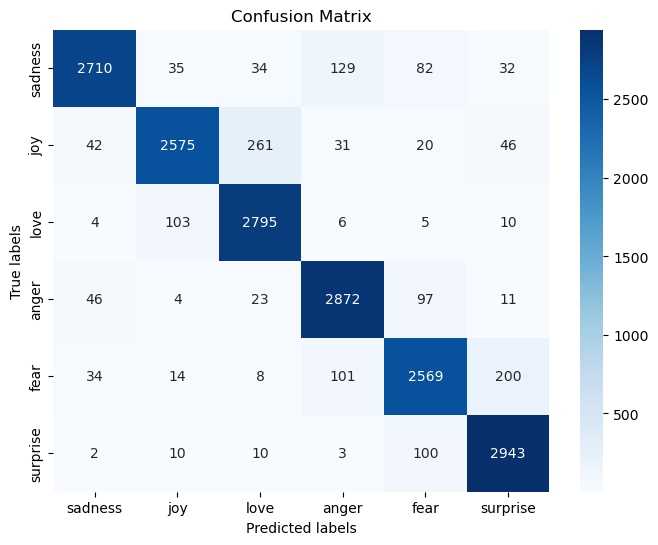

In [44]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(yTest, yPred)
plt.figure(figsize=(8, 6))
# sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=[ 'sadness',  'joy', 'love', 'anger', 'fear', 'surprise'], yticklabels=[ 'sadness',  'joy', 'love', 'anger', 'fear', 'surprise'])
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
from sklearn.model_selection import cross_val_score
cvScores = cross_val_score(rf_classifier, xTrain, yTrain, cv=5, scoring="accuracy")
print("Cross-Validation Scores:", cv_scores)
print("Mean CV Score:", np.mean(cv_scores))

# Naive Bayes

In [70]:


X = balanced_df['text'].values
Y = balanced_df['label'].values
vectorizer = TfidfVectorizer()
vectorizer.fit(X)
X = vectorizer.transform(X)

In [71]:
param_grid = {
    'alpha': [0.1, 0.5, 1.0]
}
nbClassifier = MultinomialNB()

In [74]:
grid_search = GridSearchCV(nbClassifier, param_grid, cv=5, n_jobs=-1, verbose=1)
grid_search.fit(xTrain, yTrain)
print("Best hyperparameters:", grid_search.best_params_)


Fitting 5 folds for each of 3 candidates, totalling 15 fits
Best hyperparameters: {'alpha': 1.0}


In [75]:
nbClassifier.fit(xTrain, yTrain)

MultinomialNB()

In [76]:
yPred = nbClassifier.predict(xTest)
print(classification_report(yTest, yPred))

              precision    recall  f1-score   support

           0       0.90      0.88      0.89      2953
           1       0.87      0.83      0.85      2962
           2       0.88      0.91      0.89      3049
           3       0.91      0.89      0.90      2937
           4       0.87      0.85      0.86      3022
           5       0.86      0.92      0.89      3044

    accuracy                           0.88     17967
   macro avg       0.88      0.88      0.88     17967
weighted avg       0.88      0.88      0.88     17967



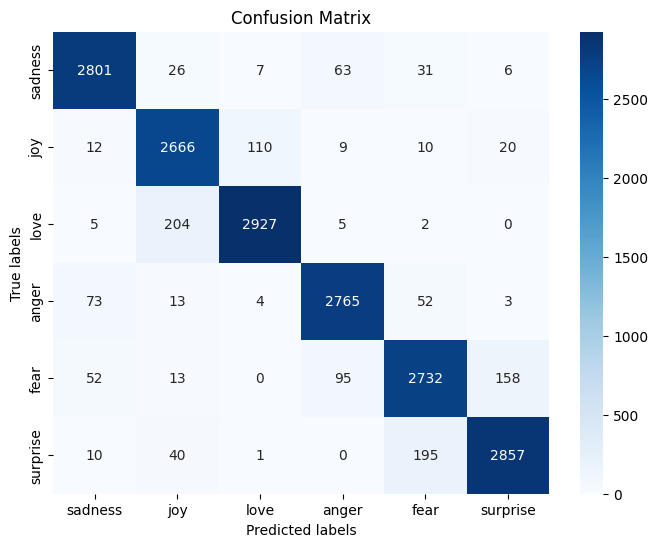

In [77]:
cm = confusion_matrix(y_pred_class, yTest_class)
plt.figure(figsize=(8, 6))
# sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=[ 'sadness',  'joy', 'love', 'anger', 'fear', 'surprise'], yticklabels=[ 'sadness',  'joy', 'love', 'anger', 'fear', 'surprise'])
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

# LSTM

In [46]:
# Same random state is used as above so test and train set is same as above models.
xTrain, xTest, yTrain, yTest = train_test_split(balanced_df['text'], balanced_df['label'], test_size=0.2,random_state=20, shuffle=True)

In [47]:
# Information from after data cleaning and finding the max length, done above. 
maxLen = 79

In [48]:
# Defined in src/LSTMModel
lstm = LSTMModel()
lstm.set_max_len(maxLen)

In [49]:
# Defined in src/LSTMModel ---> Input > Bidirectional(LSTM) > Dropout > Bidirectional(LSTM) > Dropout > Dense > Activation
lstm.build_model()

the length is 79


2024-03-15 04:59:41.649557: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2
2024-03-15 04:59:41.651379: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2024-03-15 04:59:41.651943: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2024-03-15 04:59:41.652773: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-03-15 04:59:41.653544: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [50]:
# loss = categorical crossentropy, optimizer = adam, and metric = accuracy
# compile and view summary
lstm.model_compile()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 79)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Embedding)           │ (None, 79, 50)         │    20,000,050 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 79, 256)        │       183,296 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 79, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 256)            │       394,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 6)              │         1,542 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 6)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,579,128 (78.50 MB)

 Trainable params: 20,579,128 (78.50 MB)

 Non-trainable params: 0 (0.00 B)

None


In [51]:
# model input are one hot encoded, tokenized. epochs 10, batch size 1000
history = lstm.model_fit(xTrain, yTrain, xTest, yTest)

(71865, 79)
(17967, 79)
Epoch 1/20


2024-03-15 05:00:04.846430: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


72/72 ━━━━━━━━━━━━━━━━━━━━ 132s 2s/step - accuracy: 0.3560 - loss: 1.5606 - val_accuracy: 0.7063 - val_loss: 0.7960
Epoch 2/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 139s 2s/step - accuracy: 0.7703 - loss: 0.6456 - val_accuracy: 0.8885 - val_loss: 0.3255
Epoch 3/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 154s 2s/step - accuracy: 0.9028 - loss: 0.2944 - val_accuracy: 0.9195 - val_loss: 0.2347
Epoch 4/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 171s 2s/step - accuracy: 0.9269 - loss: 0.2145 - val_accuracy: 0.9274 - val_loss: 0.2103
Epoch 5/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 127s 2s/step - accuracy: 0.9369 - loss: 0.1738 - val_accuracy: 0.9317 - val_loss: 0.1909
Epoch 6/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 208s 3s/step - accuracy: 0.9455 - loss: 0.1448 - val_accuracy: 0.9342 - val_loss: 0.1788
Epoch 7/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 213s 3s/step - accuracy: 0.9497 - loss: 0.1316 - val_accuracy: 0.9367 - val_loss: 0.1758
Epoch 8/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 205s 3s/step - accuracy: 0.9522 - loss: 0.1214 - val_accuracy: 0.9333 - val_loss: 0.

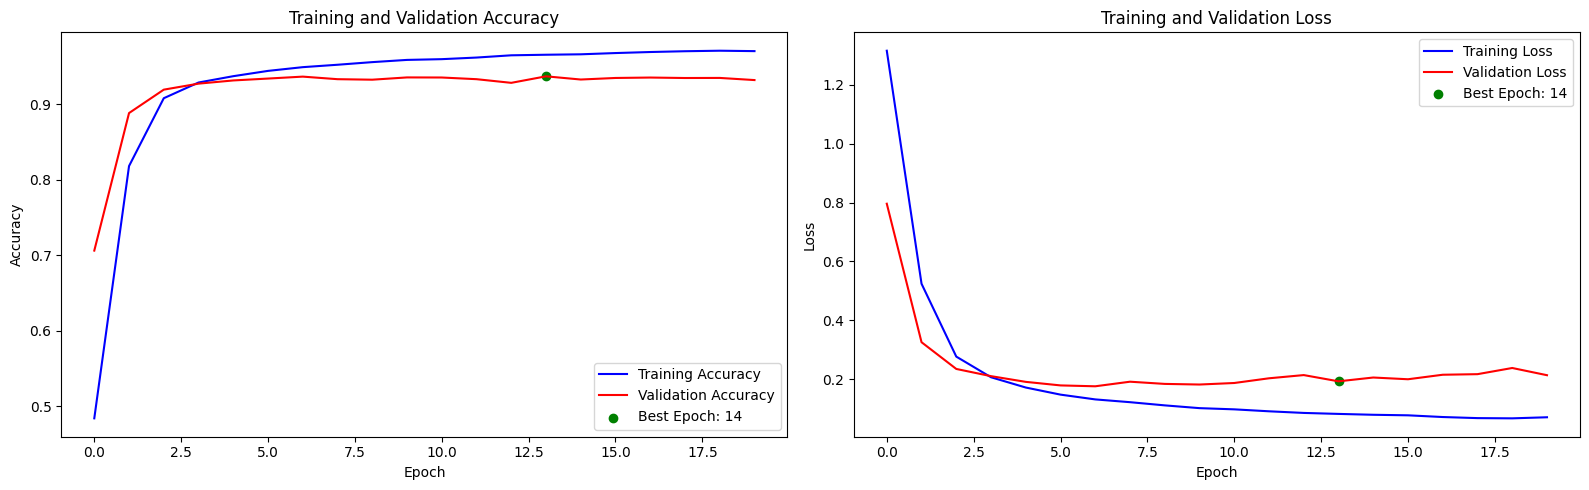

In [52]:
lstm.draw_training_graphs(history)

In [57]:
# test = np.array([ 'i am sad'])
# print(lstm.model_predict(test))

yPred = lstm.model.predict(lstm.tokenize(np.array(xTest)))


(17967, 79)
562/562 ━━━━━━━━━━━━━━━━━━━━ 12s 19ms/step
[[2.1613014e-05 3.5845564e-04 2.2644777e-05 5.6523368e-06 1.4050296e-04
  9.9945110e-01]
 [5.4091070e-05 6.1362842e-04 5.8315076e-05 2.4170062e-05 9.4104366e-04
  9.9830878e-01]
 [2.3780289e-05 9.9985003e-01 1.1606207e-04 1.9741749e-06 2.1977414e-06
  5.7860216e-06]
 ...
 [2.2517215e-05 5.1925640e-04 2.7692817e-05 8.4499816e-06 1.8222160e-04
  9.9923992e-01]
 [1.7287455e-05 1.4171111e-04 1.3575681e-05 2.2011109e-06 3.7842550e-05
  9.9978751e-01]
 [9.9979275e-01 5.6829285e-05 3.7378600e-06 6.5454471e-05 7.5663083e-05
  5.6339495e-06]]


In [58]:
yPred.shape

(17967, 6)

In [65]:
y_pred_class = np.argmax(yPred, axis=1)
yTest_class = np.asarray(yTest)

In [67]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_pred_class, yTest_class)
print(cm)

[[2801   26    7   63   31    6]
 [  12 2666  110    9   10   20]
 [   5  204 2927    5    2    0]
 [  73   13    4 2765   52    3]
 [  52   13    0   95 2732  158]
 [  10   40    1    0  195 2857]]


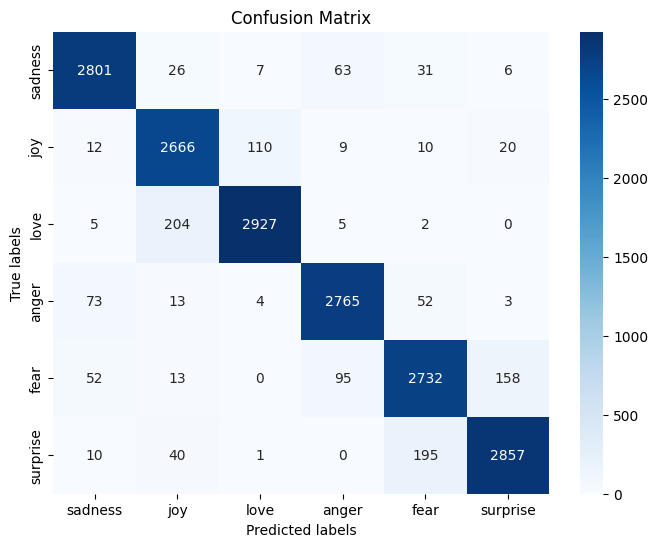

In [68]:
plt.figure(figsize=(8, 6))
# sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=[ 'sadness',  'joy', 'love', 'anger', 'fear', 'surprise'], yticklabels=[ 'sadness',  'joy', 'love', 'anger', 'fear', 'surprise'])
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

In [69]:
print(classification_report(y_pred_class, yTest_class))

              precision    recall  f1-score   support

           0       0.95      0.95      0.95      2934
           1       0.90      0.94      0.92      2827
           2       0.96      0.93      0.95      3143
           3       0.94      0.95      0.95      2910
           4       0.90      0.90      0.90      3050
           5       0.94      0.92      0.93      3103

    accuracy                           0.93     17967
   macro avg       0.93      0.93      0.93     17967
weighted avg       0.93      0.93      0.93     17967

